In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Hybrid Monte Carlo functions

In [2]:
def HMC_1step(eps, L, current_q, current_p, Uf, grad_Uf, print_flag=False):
    # this function implements 1 step of Hamilton Monte Carlo procedure                                                                                                
    # using leapfrog algorithm for the differential equation                                                                                                           
    # taken from 1206.1901                                                                                                                                             

    q_history = []
    q0 = current_q
    q = q0
    q_history.extend(q)
    
    p = current_p
    #p = np.array([-1.,1.]) #np.array([-1.,1.]) #np.random.standard_normal(len(q))                                                                                      
    #current_p =  p

    # Leapfrog algorithm starts here                                                                                                                                   
    # +++++++++++++++++++++++++++++++                                                                                                                                  
    # make half a step for momentum at the beginning                                                                                                                   
    p = p - 0.5*eps*grad_Uf(q)

    # alternate full steps for position and momentum                                                                                                                   
    for i in range(1,L+1):
        # make a full step for the position                                                                                                                            
        q += eps*p
        q_history.extend(q)
         #make a full step for the momentum, except at the end of the trajectory                                                                                       
        if(i != L):
            p += - eps*grad_Uf(q)

    q_history=np.array(q_history).reshape((-1,2))
    #make a half step for momentum at the end                                                                                                                          
    p += -0.5*eps*grad_Uf(q)

    #++++++++++++++++++++++++++++++++                                                                                                                                  
    #negate momentum at the end of the trajectory to the the proposal symmetric                                                                                        
    p = -p

    # evaluate potential and kinetic energies at the start and end of trajectory                                                                                       
    current_U = Uf(current_q)
    current_K = 0.5*np.sum(current_p**2)
    proposed_U = Uf(q)
    proposed_K = 0.5*np.sum(p**2)

    #Accept of reject the state at the end of trajectory                                                                                                               
    log_prob = min(0, -proposed_U + current_U - proposed_K + current_K )
    log_coin_toss = np.log(np.random.rand())
    if (log_coin_toss < log_prob):
        if(print_flag):
            print('accepted')
        return q, q_history
    else:
        if(print_flag):
            print('rejected')
        return q_history[0], q_history


In [15]:
def hmc_chain(eps, L, current_q, current_p, Uf, grad_Uf, N_steps, print_flag=False):
    # this function builds the Markov Chain

    q = current_q
    chain_history=[]
    chain_history.extend(q)
    for i in range(N_steps):
        q,q_history = HMC_1step(eps, L, q, current_p, Uf, grad_Uf, print_flag)
        chain_history.extend(q)

    chain_history = np.array(chain_history).reshape((-1,2))
    return chain_history


## Objective function and its gradient, specific to the problem

In [4]:
def U(x,mu,Sigma):
    # negative log of a multivariate normal                                                                                                                            
    d = len(x)
    num = 0.5*np.matmul(np.transpose(x-mu),
                        np.matmul(np.linalg.inv(Sigma),x-mu))
    return  num + np.log( (2.*np.pi)**(d/2.) * np.linalg.det(Sigma)**0.5 )

def grad_U(x,mu,Sigma):
    # grad wrt x                                                                                                                                                       
    return np.matmul(np.linalg.inv(Sigma),x-mu)


## main:

### HMC parameters

In [5]:
# Leapfrog parameters
eps = 0.25
L =25

# Markov chain # of steps
Nchain_steps = 200

### Encapsulated call to the objective function

In [6]:
mean = np.array([0.,0.])
Sigma = np.array([[1.,0.95],[0.95,1.]])

def Uf(q):
    return U(q,mean,Sigma)

def grad_Uf(q):
    return grad_U(q,mean,Sigma)

### Initial point in (q,p) space

In [29]:
q0 = np.array([-1.5,-1.55])
p0 = np.array([-1.,1.]) #np.array([-1.,1.]) #np.random.standard_normal(len(q))

##  Perform 1 step (trajectory) of the HMC procedure

In [27]:
q,q_history = HMC_1step(eps, L, q0, p0, Uf, grad_Uf, print_flag=True)
q1,q2 = q_history[:,0], q_history[:,1]

accepted


### Plotting the results

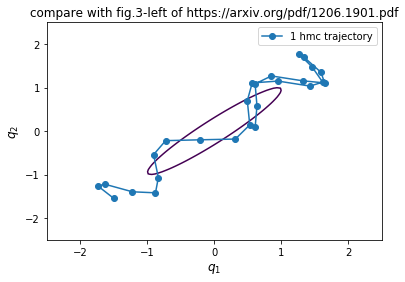

In [28]:
plt.plot(q1,q2,marker='o',label='1 hmc trajectory')


x = np.linspace(-2.5, 2.5, 100)
X, Y = np.meshgrid(x, x)
Sigma=np.array([[1,0.95],[0.95,1]])
Sigma_inv=np.linalg.inv(Sigma)
Sigma_det = np.linalg.det(Sigma)
#Z = 1/(2*np.pi) * np.exp(-(np.power(X, 2) + np.power(Y, 2))/2)
Z = 1/(2*np.pi) * (Sigma_det**(-0.5)) *np.exp(-0.5*(Sigma_inv[0,0]*X**2 + Sigma_inv[1,1]*Y**2 + 2*Sigma_inv[0,1]*X*Y))
onesigma_level = 1/(2*np.pi) * (Sigma_det**(-0.5))*np.exp(-0.5)
plt.contour(X, Y, Z, levels=[onesigma_level])
plt.legend()
plt.xlabel(r'$q_1$',fontsize=12)
plt.ylabel(r'$q_2$',fontsize=12)
plt.title('compare with fig.3-left of https://arxiv.org/pdf/1206.1901.pdf')
plt.show()